# 导入数据库

In [1]:
#数据处理库
import numpy as np
import pandas as pd
import glob
import re
import jieba

#可视化库
import stylecloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pyecharts.charts import *
from pyecharts import options as opts
from pyecharts.globals import ThemeType 
from IPython.display import Image
from palettable.colorbrewer.qualitative import Pastel1_7
plt.rcParams['font.sans-serif'] = ['Simhei'] # 解决中文乱码问题

#文本挖掘库
from snownlp import SnowNLP
from gensim import corpora,models
import csv

# 数据导入

In [14]:
df = pd.read_excel('D:\\情感分析\\data\\xiaomiqiche.xlsx',header=None)
df.columns=['原文本']
df

,原文本
0,Gamer辶辶粉丝别来引战谢谢
1,舒淇可以带个言了
2,汽车换个专门的标好吗
3,为什么我定的26-29周
4,你要放几次啊
...,...
6574,谢谢雷总1
6575,328之后，江湖再无男神，除雷军外
6576,同学们呜呜呜
6577,这个发布会真的很成功


# 数据清洗

### 1.文本去噪

爬取的原始文字语料中往往含有很多干扰信息，包括标点符号、数字、英文字母、转换符等噪声， 这些脏数据也会对情感分析产生一定影响,因此这些是我们首先要删除的，即通过文本去噪以获得干净的文本数据。

In [3]:
r1 = '[\s+\.!\/_,$%^*(+\"\')]+|[:：+——()?【】“”！，。？、~@#￥%……&*（）]+'#正则化表达式
r2 = '[^\u4e00-\u9fa5]'

df['text'] = df['原文本'].str.replace(r1,'',regex=True) #删除标点符号
df['text'] = df['原文本'].str.replace(r2,'',regex=True) #删除英文和数字
df

,原文本,text
0,Gamer辶辶粉丝别来引战谢谢,辶辶粉丝别来引战谢谢
1,舒淇可以带个言了,舒淇可以带个言了
2,汽车换个专门的标好吗,汽车换个专门的标好吗
3,为什么我定的26-29周,为什么我定的周
4,你要放几次啊,你要放几次啊
...,...,...
6574,谢谢雷总1,谢谢雷总
6575,328之后，江湖再无男神，除雷军外,之后江湖再无男神除雷军外
6576,同学们呜呜呜,同学们呜呜呜
6577,这个发布会真的很成功,这个发布会真的很成功


### 2.文本去重

In [4]:
#转换数据类型
df['text']=df['text'].astype('string')

In [5]:
#去除重复值
df['text'].drop_duplicates(inplace=True)
#删除存在缺失值的行
df = df[df['text']!='']
df = df[df['text']!=' ']
#恢复索引
df.index = range(df.shape[0])
df.shape

(6414, 2)

In [6]:
df.to_excel("D:\\情感分析\\result\\数据清洗后结果.xlsx")

# 情感分析

## 使用SnowNLP进行情感分析

Snow NLP是适用于中文自然语言处理的Python类库，专门针对中文文本进行挖掘， 主要可以进行中文分词、词性标注、情感分析、文本分类、转换拼音、繁体转简体、提取文本关键词、提取摘要、分割句子、文本相似。

In [7]:
#利用SnowNlP库将评论数据分为正面评论、负面评论和中性评论
#得分值大于0.6判定为正面，小于0.4为负面，其余为中性
df['semiscore'] = df['text'].apply(lambda x:SnowNLP(x).sentiments)

df['semilabel'] = 0
for i in range(len(df['semiscore'])):
    if df['semiscore'][i] > 0.6:
        df['semilabel'][i] = 1
    elif df['semiscore'][i] < 0.4:
        df['semilabel'][i] = -1
    else:
        df['semilabel'][i] = 0
df[['text','semiscore','semilabel']]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11868\987842596.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['semilabel'][i] = 1
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11868\987842596.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['semilabel'][i] = 0
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11868\987842596.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['semilabel'][i] = -1


,text,semiscore,semilabel
0,辶辶粉丝别来引战谢谢,0.885389,1
1,舒淇可以带个言了,0.572701,0
2,汽车换个专门的标好吗,0.956940,1
3,为什么我定的周,0.772016,1
4,你要放几次啊,0.427381,0
...,...,...,...
6409,谢谢雷总,0.438221,0
6410,之后江湖再无男神除雷军外,0.157255,-1
6411,同学们呜呜呜,0.378378,-1
6412,这个发布会真的很成功,0.141325,-1


In [8]:
df.sort_values(by="semiscore" , ascending=False) 

,原文本,text,semiscore,semilabel
4577,华为不合作怎么支持华为？你去说服华为开放合作，小米立马就适配华为,华为不合作怎么支持华为你去说服华为开放合作小米立马就适配华为,0.999996,1
4127,遥遥领先遥遥领先,遥遥领先遥遥领先,0.999993,1
6035,10年后 感谢你当初勇敢的选择第一辆小米汽车 现在金额全部返还将成为绝杀,年后感谢你当初勇敢的选择第一辆小米汽车现在金额全部返还将成为绝杀,0.999902,1
5149,特斯拉的算法确实强，但能在国内落地其实是遥遥无期的。目前自动驾驶仪还是概念多于实际，国家层面...,特斯拉的算法确实强但能在国内落地其实是遥遥无期的目前自动驾驶仪还是概念多于实际国家层面有没有...,0.999893,1
4434,酱香清香浓香,酱香清香浓香,0.999884,1
...,...,...,...,...
4532,格局拉满，嘲讽也拉满,格局拉满嘲讽也拉满,0.000204,-1
1505,车漆研发那可是太高科技了 你看隔壁都弄出反雷达隐身涂料了,车漆研发那可是太高科技了你看隔壁都弄出反雷达隐身涂料了,0.000101,-1
2064,天幕败笔，过两年夏天热死，晒脱皮，搞不好空调功率干不过太阳，续航更差,天幕败笔过两年夏天热死晒脱皮搞不好空调功率干不过太阳续航更差,0.000095,-1
5014,没人关心这些自动化设备是怎么来的，并且术业有专攻，小米除非没事做，否则不可能去研究这个流水线...,没人关心这些自动化设备是怎么来的并且术业有专攻小米除非没事做否则不可能去研究这个流水线的设备...,0.000066,-1


In [9]:
df.to_excel("D:\\情感分析\\result\\情感分析结果.xlsx")

In [10]:
# 多条件筛选时
a=df[(df['semilabel'] == 1)]
b=df[(df['semilabel'] == 0)]
c=df[(df['semilabel'] == -1)]

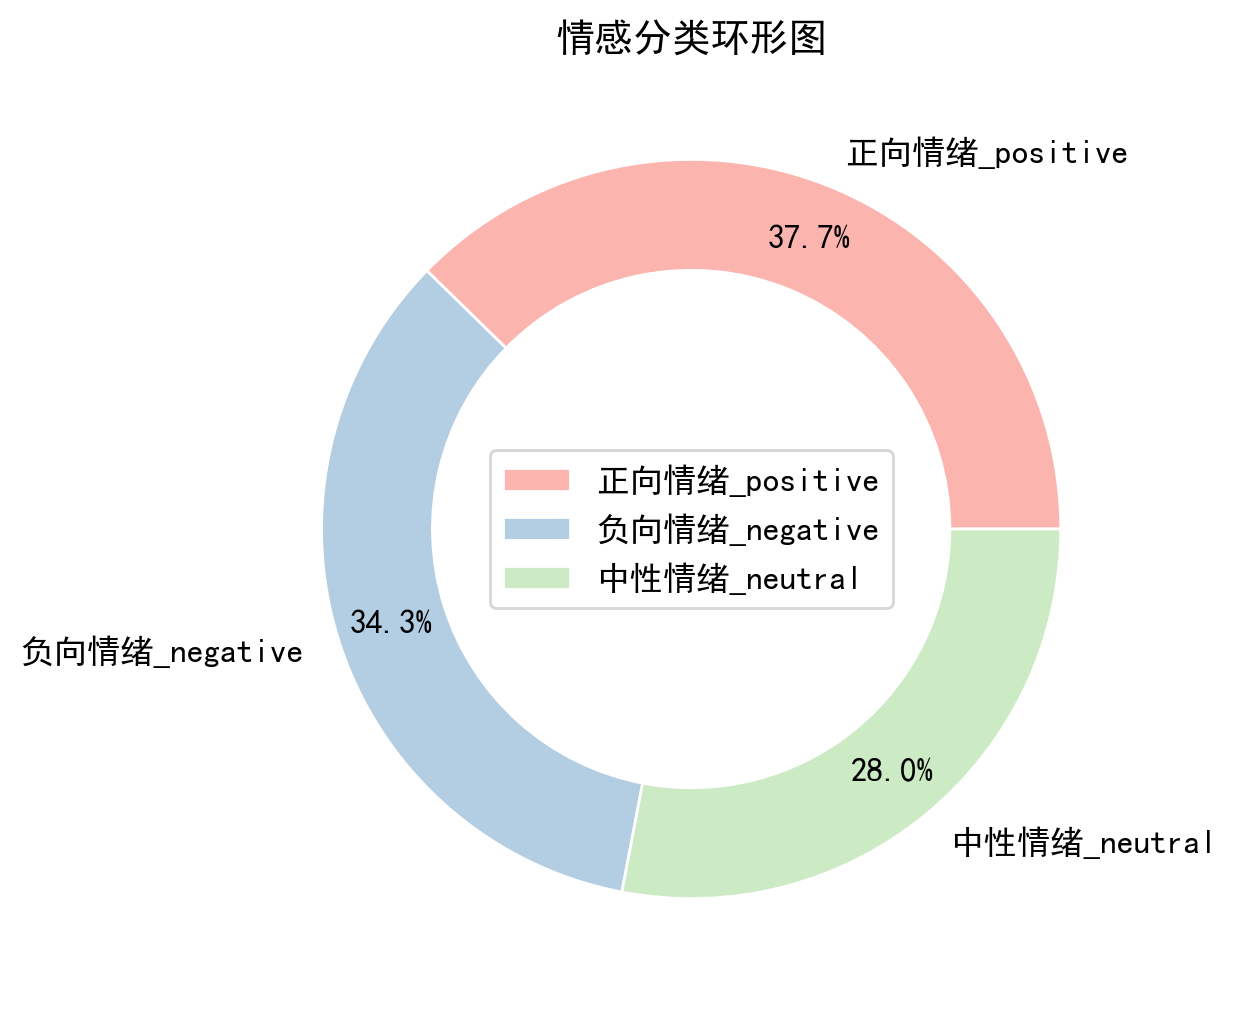

In [11]:
x = ['正向情绪_positive', '负向情绪_negative','中性情绪_neutral']
y = [a.shape[0],c.shape[0],b.shape[0]]
plt.figure(dpi=200,figsize=(10, 6)) #设置画布大小
plt.pie(y,pctdistance=0.85,autopct='%.1f%%', textprops={'fontsize': 12},labels=x, colors=Pastel1_7.hex_colors, wedgeprops=dict(width=0.3, edgecolor='w'))
plt.legend(x,loc='center',fontsize=12)
plt.title('情感分类环形图',fontsize=14)
plt.savefig('D:\\情感分析\\result\\情感分类环形图')
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11868\1502989849.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(rate,


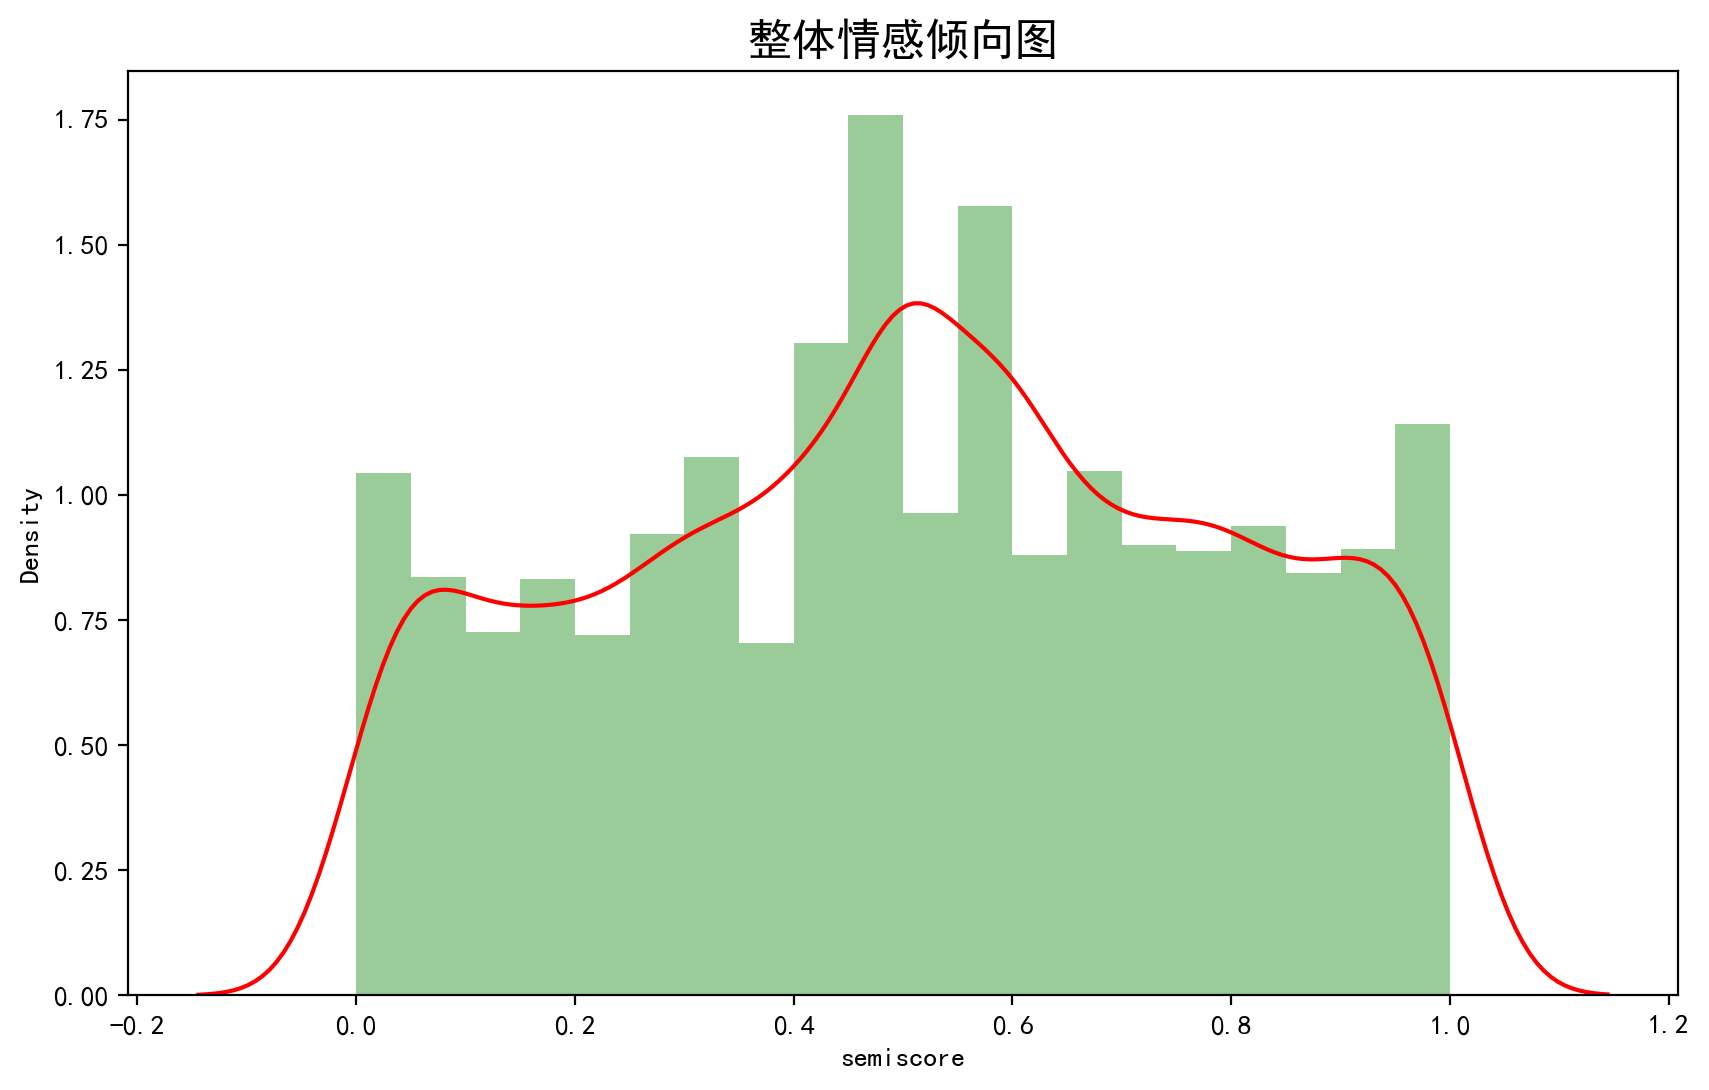

In [12]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置加载的字体名

plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

plt.figure(dpi=200,figsize=(10, 6)) #设置画布大小

rate = df['semiscore']
#sns.set(style="white",font_scale=1.4)
ax = sns.distplot(rate,

            hist_kws={'color':'green','label':'直方图'},

            kde_kws={'color':'red','label':'密度曲线'},

            bins=20) #参数color样式为salmon，bins参数设定数据片段的数量

ax.set_title("整体情感倾向图",fontsize = 16)
plt.savefig('D:\\情感分析\\result\\整体情感倾向图')
plt.show()

## 训练 

准备消极和积极情感的文本，分别为neg.txt和pos.txt

In [13]:
from snownlp import sentiment
sentiment.train('neg.txt', 'pos.txt')
sentiment.save("sentiment.marshal")

将训练好的模型sentiment.marshal放到软件snownlp工具包安装路径下